# Mutual Information in SimClr

In this notebook, we want to demystify what's happening to the encoder in the SimClr  https://arxiv.org/abs/2002.05709  as we train it. We use the same notation as in the paper where, x is an image, h = resnet(x), z = g(h) where g is a NN with one hidden layer. <br>

We take a look at the mutual information <br>
I(x;z) = H(z) -E_x(H(z|x)) <br>

which (according to wikipedia) quantifies the "amount of information" (in units such as shannons, commonly called bits) obtained about one random variable through observing the other random variable. <br>

Since it's difficult to calculate the entropy we approximated it using the upper bound from inequalities <br>
H(u) <= 0.5*log(2pi*e) + 0.5*log(det(cov(u)) <= 0.5*log(2pi*e) + 0.5*log(trace(cov(u))<br>
So we are interested in two quantities, log det of covariance matrix and trace of covariance matrix.


### calculation for h

* for h (or z), we sample B images from the dataset (train or test set) x1,x2,...xB
* apply augmentation to each image
* apply an encoder to calculate h (or z)
* calculate a covariance matrix of h1,h2,...hB , C which is a DxD matrix where D is the dimension of h(or z)

### calculation for h|x

* for h|x (or z|x) we sample B images from the dataset (train or test set) x1,x2,...xB
* for each xi, we generate A images by applying random augmentations xi1, xi2, ... xiA
* apply an encoder to get hi1,hi2, ... hiA and calculate a covariance matrix Ci
* calculate trace or logdet of each Ci
* take an average of trace (or logdet) from C1, C2, ... CB

In [1]:
import os
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import numpy as np
from configs import get_datasets
from critic import LinearCritic
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from PIL import Image
from models import *
import torch.backends.cudnn as cudnn
from tqdm import tqdm
import math
import seaborn as sns


### config ####
num_workers = 2
batch_size = 512
img_size = 32
temperature = 0.5
dataset = 'cifar10'
CACHED_MEAN_STD = {
        'cifar10': ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        'cifar100': ((0.5071, 0.4865, 0.4409), (0.2009, 0.1984, 0.2023)),
        'stl10': ((0.4409, 0.4279, 0.3868), (0.2309, 0.2262, 0.2237)),
        'imagenet': ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    }

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
##### Transformation #####
def ColourDistortion(s=1.0):
    # s is the strength of color distortion.
    color_jitter = transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
    rnd_color_jitter = transforms.RandomApply([color_jitter], p=0.8)
    rnd_gray = transforms.RandomGrayscale(p=0.2)
    color_distort = transforms.Compose([rnd_color_jitter, rnd_gray])
    return color_distort


transform_train = transforms.Compose([
        transforms.RandomResizedCrop(img_size, interpolation=Image.BICUBIC),
        transforms.RandomHorizontalFlip(),
        ColourDistortion(s=0.5),
        transforms.ToTensor(),
        transforms.Normalize(*CACHED_MEAN_STD[dataset]),
    ])


# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Files already downloaded and verified
Files already downloaded and verified


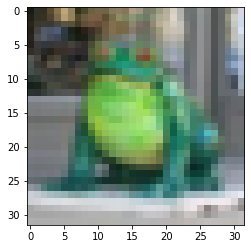

In [3]:
root = '/data/cifar10/'
train = torchvision.datasets.CIFAR10(root = root, train=True, download=True)
test = torchvision.datasets.CIFAR10(root = root, train = False, download = True)
pic = train[19][0]
plt.imshow(pic)

# Code for generate data

In [4]:
##### generate data ######

root = '/data/cifar10/'
train = torchvision.datasets.CIFAR10(root = root, train=True, download=True)
test = torchvision.datasets.CIFAR10(root = root, train = False, download = True)
    
def x_to_xaug(data, sample = 100, index = 0):
    '''
    Input : a list of picture, index of the pic we want, sample = number of sample generate 
    
    Output: list of pictures each have random augmentations on it
    '''
    x = []
    original_pic = data[index][0]
    for i in range(sample):
        transform_pic = transform_train(original_pic)
        x.append(transform_pic)
    return x

def gen_data(B = 500, sample = 100):
    '''
    B = image batch
    num_aug = number of augmented picture for each image 
    
    return x_train, x_test (list) [[pic1_aug1, pic1_aug2, ..., pic1_augA], [pic2_aug1, pic2_aug2, ...], ..., [picB_aug1,....picB_augA]]
    '''
    idx_train = np.random.randint(low = 0, high = len(train), size = B)
    idx__test = np.random.randint(low = 0, high = len(test), size = B)
    #sample augmented image !
    X_train = [x_to_xaug(data = train, sample = sample, index = idx_train[i]) for i in range(B)]
    X_test = [x_to_xaug(data = test, sample = sample, index = idx__test[i]) for i in range(B)]
    
    return X_train, X_test


# get data for x with only one sample for each image 
def gen_data_1pic(B = 100):
    '''
    the main difference between this function and gen_data is that this function return
    a list [[pic1_aug, pic2_aug, ..., picB_aug]] each original picture is selected once
    '''
    train, test = gen_data(B=B, sample = 1)
    X_train1 = [train[i][0] for i in range(len(train))]
    X_test1 = [test[i][0] for i in range(len(test))]
    return [X_train1], [X_test1]


Files already downloaded and verified
Files already downloaded and verified


# Code for calculating h, z, covariance matrix

In [5]:
##### load net, critics Resnet18 checkpoint ######
def get_net(filename):
    '''
    Input: checkpoint filename
    Return: net, critic
     
    '''
    
    net = ResNet18()
    net = net.to(device)

    if device == 'cuda':
        repr_dim = net.representation_dim
        net = torch.nn.DataParallel(net)
        net.representation_dim = repr_dim
        cudnn.benchmark = True

    #print('==> Loading encoder from checkpoint..')
    resume_from = os.path.join('./checkpoint', filename)
    checkpoint = torch.load(resume_from)
 
    net.load_state_dict(checkpoint['net'])
    
    
    #load critics
    critics = LinearCritic(net.representation_dim, temperature=temperature).to(device)
    critics.load_state_dict(checkpoint['critic'])
    
    return net, critics

In [6]:
#calculating h, z from x
def x_to_h(x, net):
    '''
    Input list[tensor] , net
    
    return list[tensor]
    '''
    h = []
    net.eval()
    with torch.no_grad():
        for i in range(len(x)):
            x_i = x[i].unsqueeze(0)
            h_i = net(x_i)
            h_i = h_i/h_i.norm(p=2, dim=-1, keepdim = True)
            h.append(h_i)
    return h

def h_to_z(h, critics):
    '''
    Input list[tensor] , critics
    
    return list[tensor]
    '''
    z = []
    critics.eval()
    with torch.no_grad():
        for i in range(len(h)):
            z_i = critics.project(h[i])
            z.append(z_i)
    return z

In [7]:
#calculate covariance matrix from a list of h
def h_to_cov(h):
    '''
    h = list(tensor1, tensor2, ...)
    
    return 512x512 covariance matrix 
    '''
    B = len(h)
    H_torch = torch.stack(h).squeeze(1)
    H_torch_mean = H_torch.mean(dim = 0)
    H_torch_mean = H_torch_mean.repeat(B,1)
    
    H_torch_norm = H_torch- H_torch_mean
    cov_H = 1/(B-1) * torch.matmul(H_torch_norm.transpose(0,1), H_torch_norm)
    
    return cov_H


def cov_to_trace(cov_H):
    '''
    Input covariance tensor
    return trace
    '''
    return cov_H.trace()

def cov_to_logdet(cov_H, buffer = 1):
    '''
    Input covariance tensor
    return logdet of (covariance matrix + buffer* identity)
    '''
    return (cov_H + (torch.eye(cov_H.size()[0])*buffer).to(device)).det().log()

# Code for calculation

In [8]:
def x_to_cov(X, filename):
    '''
    Input: X is a list of list of tensor
        [[tensor11,tensor12,...,], .... [tensorn1,tensorn2, ....]]
        
    filename = checkpoint filename
    Return: a list of covariance matrix
    [cov_tensor1, cov_tensor2, ...., cov_tensorn]
    '''
    net, critics = get_net(filename)
    
    cov_H = []
    cov_Z = []
    for i in range(len(X)):
        x_i = X[i]  # list of augmented images that come from the same original pic
        h_i = x_to_h(x_i, net)
        z_i = h_to_z(h_i, critics)
        cov_h_i = h_to_cov(h_i) # calculate covariance matrix
        cov_z_i = h_to_cov(z_i)
        
        cov_H.append(cov_h_i)
        cov_Z.append(cov_z_i)
        
    return cov_H, cov_Z

def x_to_logdet(X, filename):
    '''
    Input: X is a list of list of tensor
        [[tensor11,tensor12,...,], .... [tensorn1,tensorn2, ....]]
        
    filename = checkpoint filename
    Return: a list of log det of covariance matrix
    [logdet_cov_tensor1, logdet_cov_tensor2, ...., logdet_cov_tensorn]
    '''
    
    net, critics = get_net(filename)
    
    logdet_H = []
    logdet_Z = []
    for i in range(len(X)):
        x_i = X[i]  # list of augmented images that come from the same original pic
        h_i = x_to_h(x_i, net)
        z_i = h_to_z(h_i, critics)
        cov_h_i = h_to_cov(h_i) # calculate covariance matrix
        cov_z_i = h_to_cov(z_i)
        
        logdet_H.append(cov_to_logdet(cov_h_i))
        logdet_Z.append(cov_to_logdet(cov_z_i))
        
        
    return torch.tensor(logdet_H), torch.tensor(logdet_Z)



def x_to_trace(X, filename):
    
    '''
    Input: X is a list of list of tensor
        [[tensor11,tensor12,...,], .... [tensorn1,tensorn2, ....]]
        
    filename = checkpoint filename
    Return: a list of trace of covariance matrix
    [trace_cov_tensor1, trace_cov_tensor2, ...., trace_cov_tensorn] for h and z
    '''
    
    net, critics = get_net(filename)
    
    trace_H = []
    trace_Z = []
    for i in range(len(X)):
        x_i = X[i]  # list of augmented images that come from the same original pic
        h_i = x_to_h(x_i, net)
        z_i = h_to_z(h_i, critics)
        cov_h_i = h_to_cov(h_i) # calculate covariance matrix
        cov_z_i = h_to_cov(z_i)
        
        trace_H.append(cov_to_trace(cov_h_i))
        trace_Z.append(cov_to_trace(cov_z_i))
        
    return torch.tensor(trace_H), torch.tensor(trace_Z)
       


In [9]:
base200 = ['inv-gp-0_run1_epoch199.pth','inv-gp-0_run2_epoch199.pth','inv-gp-0_run3_epoch199.pth','inv-gp-0_run4_epoch199.pth','inv-gp-0_run5_epoch199.pth']
base150 = ['inv-gp-0_run1_epoch149.pth','inv-gp-0_run2_epoch149.pth','inv-gp-0_run3_epoch149.pth','inv-gp-0_run4_epoch149.pth','inv-gp-0_run5_epoch149.pth']
base100 = ['inv-gp-0_run1_epoch099.pth','inv-gp-0_run2_epoch099.pth','inv-gp-0_run3_epoch099.pth','inv-gp-0_run4_epoch099.pth','inv-gp-0_run5_epoch099.pth']
base50 =  ['inv-gp-0_run1_epoch049.pth','inv-gp-0_run2_epoch049.pth','inv-gp-0_run3_epoch049.pth','inv-gp-0_run4_epoch049.pth', 'inv-gp-0_run5_epoch049.pth']
base = [base50, base100, base150, base200]

In [10]:
gp200 = ['inv-gp-1_norm_run1_epoch199.pth','inv-gp-1_norm_run2_epoch199.pth','inv-gp-1_norm_run3_epoch199.pth', 'inv-gp-1_norm_run4_epoch199.pth','inv-gp-1_norm_run5_epoch199.pth']
gp150 = ['inv-gp-1_norm_run1_epoch149.pth','inv-gp-1_norm_run2_epoch149.pth', 'inv-gp-1_norm_run3_epoch149.pth','inv-gp-1_norm_run4_epoch149.pth','inv-gp-1_norm_run5_epoch149.pth']
gp100 = ['inv-gp-1_norm_run1_epoch099.pth','inv-gp-1_norm_run2_epoch099.pth', 'inv-gp-1_norm_run3_epoch099.pth', 'inv-gp-1_norm_run4_epoch099.pth','inv-gp-1_norm_run5_epoch099.pth']
gp50 = ['inv-gp-1_norm_run1_epoch049.pth','inv-gp-1_norm_run2_epoch049.pth','inv-gp-1_norm_run3_epoch049.pth', 'inv-gp-1_norm_run4_epoch049.pth', 'inv-gp-1_norm_run5_epoch049.pth']
gp = [gp50, gp100, gp150, gp200]

In [11]:
# helper function
def cal_trace(X, checkpointfile):
    h_list = []
    z_list = []
    for file in checkpointfile:
#         print(file)
        trace_h, trace_z = x_to_trace(X, file)
        h_list.append(trace_h)
        z_list.append(trace_z)
    h_list = torch.stack(h_list)
    z_list = torch.stack(z_list)
    return h_list, z_list

In [12]:
# helper function
def cal_logdet(X, checkpointfile):
    h_list = []
    z_list = []
    for file in checkpointfile:
#         print(file)
        logdet_h, logdet_z = x_to_logdet(X, file)
        h_list.append(logdet_h)
        z_list.append(logdet_z)
    h_list = torch.stack(h_list)
    z_list = torch.stack(z_list)
    return h_list, z_list

# E(h|x), E(z|x)

In [13]:
#100 images, 50 augmentation for each image
X_h_giv_x, X_h_giv_x_test = gen_data(B=100, sample = 10)

In [14]:
def cal_(X, checkpoint_list, mode):
    h_list = []
    z_list = []
    for file in tqdm(checkpoint_list):
        if (mode == 'trace'):           
            h, z = cal_trace(X, file)
        elif (mode == 'logdet'):
            h, z = cal_logdet(X, file)
        h_list.append(h)
        z_list.append(z)
    h_list = torch.stack(h_list)
    z_list = torch.stack(z_list)
    
    return h_list, z_list

In [15]:
base_tr_h_x, base_tr_z_x = cal_(X_h_giv_x, base, mode = 'trace')
base_logdet_h_x, base_logdet_z_x = cal_(X_h_giv_x, base, mode = 'logdet')

100%|██████████| 4/4 [02:03<00:00, 30.79s/it]


In [16]:
gp_tr_h_x, gp_tr_z_x = cal_(X_h_giv_x, gp, mode = 'trace')
gp_logdet_h_x, gp_logdet_z_x = cal_(X_h_giv_x, gp, mode = 'logdet')

100%|██████████| 4/4 [02:02<00:00, 30.62s/it]


# E(h), E(z)

In [17]:
X_h , X_h_test = gen_data_1pic(B = 1000)

In [18]:
base_tr_h, base_tr_z = cal_(X_h, base, mode = 'trace')
base_logdet_h, base_logdet_z = cal_(X_h, base, mode = 'logdet')

100%|██████████| 4/4 [01:43<00:00, 25.98s/it]


In [19]:
gp_tr_h, gp_tr_z = cal_(X_h, gp, mode = 'trace')
gp_logdet_h, gp_logdet_z = cal_(X_h, gp, mode = 'logdet')

100%|██████████| 4/4 [01:43<00:00, 25.77s/it]


In [20]:
epochs = [i*50 for i in range(1,5)]

In [21]:
def plot(A,B, name):
    plt.figure(dpi = 70)
    plt.plot(epochs, A, label = 'baseline',marker = 'o')
    plt.plot(epochs, B, label = 'gp norm', marker = 'o')
    plt.xlabel('epochs')
    plt.ylabel(name)
    plt.legend()
    plt.grid(True)  

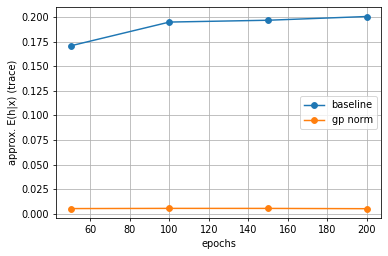

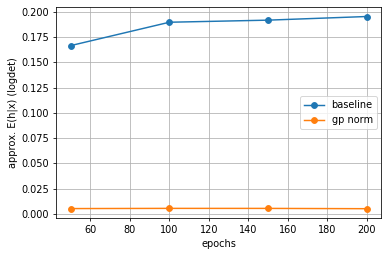

In [22]:
plot(base_tr_h_x.mean(axis = 1).mean(axis=1),
    gp_tr_h_x.mean(axis=1).mean(axis=1),
    'approx. E(h|x) (trace)')
plot(base_logdet_h_x.mean(axis = 1).mean(axis=1),
    gp_logdet_h_x.mean(axis=1).mean(axis=1),
    'approx. E(h|x) (logdet)')

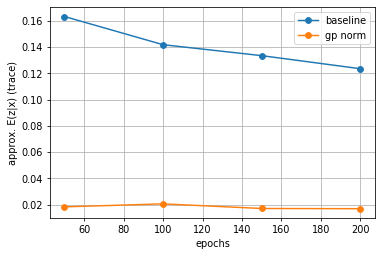

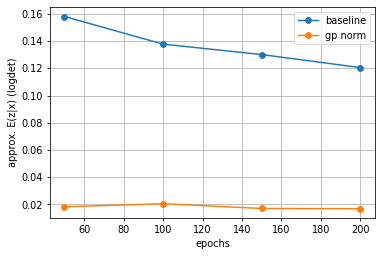

In [23]:
plot(base_tr_z_x.mean(axis = 1).mean(axis=1),
    gp_tr_z_x.mean(axis=1).mean(axis=1),
    'approx. E(z|x) (trace)')
plot(base_logdet_z_x.mean(axis = 1).mean(axis=1),
    gp_logdet_z_x.mean(axis=1).mean(axis=1),
    'approx. E(z|x) (logdet)')

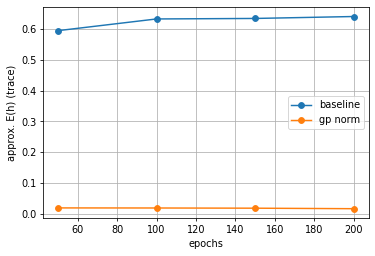

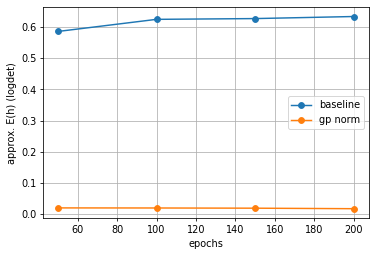

In [24]:
plot(base_tr_h.mean(axis = 1).mean(axis=1),
    gp_tr_h.mean(axis=1).mean(axis=1),
    'approx. E(h) (trace)')
plot(base_logdet_h.mean(axis = 1).mean(axis=1),
    gp_logdet_h.mean(axis=1).mean(axis=1),
    'approx. E(h) (logdet)')

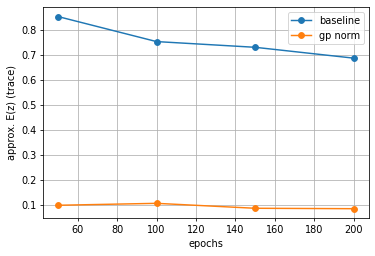

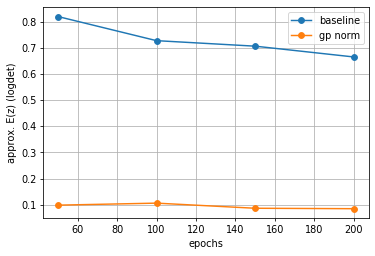

In [25]:
plot(base_tr_z.mean(axis = 1).mean(axis=1),
    gp_tr_z.mean(axis=1).mean(axis=1),
    'approx. E(z) (trace)')
plot(base_logdet_z.mean(axis = 1).mean(axis=1),
    gp_logdet_z.mean(axis=1).mean(axis=1),
    'approx. E(z) (logdet)')

# Investigate size

In [26]:
def x_to_h2(X, filename):

    net, critics = get_net(filename)
    
    H = []
    Z = []
    for i in range(len(X)):
        x_i = X[i]  # list of augmented images that come from the same original pic
        h_i = x_to_h(x_i, net)
        z_i = h_to_z(h_i, critics)
        
        H.append(h_i)
        Z.append(z_i)
        
    return H,Z

In [27]:
H,Z = x_to_h2(X_h_giv_x, 'inv-gp-0_run1_epoch199.pth')
torch.stack(H[0]).norm(p=2, dim = -1).mean()

tensor(1., device='cuda:0')

In [28]:
H,Z = x_to_h2(X_h_giv_x, 'inv-gp-0_run1_epoch099.pth')
torch.stack(H[0]).norm(p=2, dim = -1).mean()

tensor(1., device='cuda:0')

In [29]:
H,Z = x_to_h2(X_h_giv_x, 'inv-gp-1_norm_run1_epoch199.pth')
torch.stack(H[0]).norm(dim = -1, p = 2).mean()

tensor(1., device='cuda:0')

In [30]:
H,Z = x_to_h2(X_h_giv_x, 'inv-gp-1_norm_run1_epoch099.pth')
torch.stack(H[0]).norm(dim = -1, p = 2).mean()

tensor(1., device='cuda:0')

# Example code for calculating E(h|x), E(h) from checkpoint

1) gen data set <br>
- h|x use this gen function X_h_giv_x, X_h_giv_x_test = gen_data(B=100, sample = 10)<br>
- h use this gen function X_h , X_h_test = gen_data_1pic(B = 1000) <br>

2) trace_h, trace_z = x_to_trace/ x_to_logdet <br>

In [32]:
X_h_giv_x, X_h_giv_x_test = gen_data(B=100, sample = 10)

In [37]:
trace_h_giv_x, trace_z_giv_x = x_to_trace(X_h_giv_x, 'inv-gp-0_run1_epoch199.pth')

In [38]:
trace_h_giv_x

tensor([0.3447, 0.1519, 0.2237, 0.2963, 0.2771, 0.1999, 0.1561, 0.1648, 0.2317,
        0.1127, 0.2271, 0.3016, 0.2358, 0.2064, 0.2109, 0.2331, 0.1172, 0.1815,
        0.1522, 0.1958, 0.1016, 0.1917, 0.1980, 0.1568, 0.2286, 0.3221, 0.0592,
        0.1092, 0.1947, 0.2809, 0.1094, 0.0644, 0.1779, 0.2507, 0.1180, 0.1442,
        0.2986, 0.2250, 0.2033, 0.2983, 0.2613, 0.1216, 0.2881, 0.0980, 0.1527,
        0.1622, 0.1594, 0.1537, 0.2240, 0.1563, 0.1338, 0.0939, 0.2665, 0.1903,
        0.2403, 0.2443, 0.2358, 0.0870, 0.2466, 0.1367, 0.2505, 0.2779, 0.2381,
        0.1729, 0.1892, 0.1438, 0.1481, 0.1369, 0.3343, 0.1758, 0.1270, 0.1690,
        0.2109, 0.1951, 0.1563, 0.3003, 0.2423, 0.2555, 0.1278, 0.0855, 0.2046,
        0.2211, 0.1911, 0.2434, 0.1912, 0.1476, 0.2086, 0.1381, 0.1337, 0.1311,
        0.2690, 0.1218, 0.2265, 0.1548, 0.1301, 0.2350, 0.1930, 0.1832, 0.2443,
        0.1579])

In [43]:
# mean over 100 images
trace_h_giv_x.mean()

tensor(0.1927)

In [42]:
trace_h_giv_x.size()

torch.Size([100])

In [39]:
X_h , X_h_test = gen_data_1pic(B = 1000)

In [45]:
trace_h, trace_z = x_to_trace(X_h, 'inv-gp-0_run1_epoch199.pth')

In [46]:
# this value is already a mean of 1000 images
trace_h

tensor([0.6408])